# Business Problem

## Todos

Finalize/save off clean data 
- sep notebook?
- stopwords 
- POS Tagging
- Think about train/test split change
- bigrams

From each class:
- word cloud
- example tweets

Address class imbalance
- smote **

pipelines
 - smote? **
 - Vectorizer **
 - transformer **
 - model **
 - KNN **
 - XGBoost
 
Grid Searches
 - RF **
 - GBC **
 
Advanced Modeling
- NN?
- Spacy for class imbalance?

# Questions:
Dummy Classifier is misbehaving. seems like it's always predicting the minority class?

Intuition is maybe we have problems in our data still


# Data Understanding

In [1]:
# Import Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from pprint import pprint
import nltk
from sklearn.preprocessing import LabelEncoder
from matplotlib.ticker import MaxNLocator
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag, FreqDist
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, TweetTokenizer
from nltk import tokenize as tok
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, recall_score, accuracy_score, precision_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from sklearn.metrics import make_scorer
import xgboost as xgb

In [2]:
df = pd.read_csv('../data/judge-1377884607_tweet_product_company.csv', encoding= 'unicode_escape')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
df.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [5]:
df.tail()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product
9092,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...,NaN,No emotion toward brand or product


In [6]:
# Dropped the sole blank tweet_text field
df.drop(index=[6], inplace=True)

In [7]:
df['emotion_in_tweet_is_directed_at'].isna().sum()

5801

In [8]:
df["tweet_text"][6520]

"RT @mention RT @mention Can't be at #sxsw? download their free music mix on itunes {link} cc: @mention"

In [9]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [10]:
df_ict = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == "I can't tell"]

In [11]:
# Dropped the records where sentiment was labeled "I can't tell"
df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]

## Preprocessing Data

In [12]:
# Create column for target variable for easier processing
df['target'] = df['is_there_an_emotion_directed_at_a_brand_or_product']

In [13]:
# Custom regular expressions utilized for cleaning tweet-specific features (retweets, user handles, etc.)
# Credit to Prajwal @ https://gitlab.com/praj88/twitter-analytics/blob/master/scripts/twitter-analytics.ipynb

# Identify hyperlinks in the subject data.
isURL = re.compile(r'http[s]?:// (?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', re.VERBOSE | re.IGNORECASE)

# Identify usernames in retweets.
isRTusername = re.compile(r'^RT+[\s]+(@[\w_]+:)',re.VERBOSE | re.IGNORECASE) #r'^RT+[\s]+(@[\w_]+:)'

# Identify entites preceded by the @ symbol (twitter handles).
isEntity = re.compile(r'@[\w_]+', re.VERBOSE | re.IGNORECASE)

In [14]:
# Function to remove URLs, retweeted usernames and usernames from tweet data.
def clean_tweet(row):
    row = isURL.sub("",row)
    row = isRTusername.sub("",row)
    row = isEntity.sub("",row)
    return row

In [15]:
# Created a new column containing the results of applying the clean_tweet function to the raw data.
df['clean'] = df['tweet_text'].apply(lambda row:clean_tweet(row))

In [16]:
RE_PUNCTUATION = '|'.join([re.escape(x) for x in string.punctuation])  
df['clean'] = df['clean'].str.replace(RE_PUNCTUATION, "")

In [17]:
lemmatizer = WordNetLemmatizer()

def tokenize_lem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as its own token
    tokens = [word.lower() for sent in tok.sent_tokenize(text) for word in tok.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return [lemmatizer.lemmatize(token) for token in filtered_tokens]

In [18]:
df['clean'] = df['clean'].apply(tokenize_lem)

In [19]:
df['clean_joined'] = df['clean'].str.join(" ")

In [52]:
# Create Stopwords list--standard wordlist plus commonly-seen words in the dataset.
sw = stopwords.words('english')
customsw = ['sxsw', 'link', 'rt', 'apple', 'austin', 'google', 'ipad', 'iphone', 'store', 'new', 'app', 'get', 'android']      
             
            #'android', 'social']
            #'get', 'one', 'circle', 'launch', 'line', 'free', 'amp', 'popup', 'ipad2',
            #'like', 'time', 'today']
sw.extend(customsw)

In [53]:

def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in stopwords_list have been
    removed
    """
    stopwords_r = [token for token in token_list if token not in sw]
    return stopwords_r

In [54]:
df['clean'] = df['clean'].apply(remove_stopwords)

In [55]:
df['stop_r'] = df['clean'].str.join(" ")

In [56]:
df['stop_r']

0       3g hr tweeting riseaustin wa dead need upgrade...
1       know awesome ipadiphone youll likely appreciat...
2                                          wait also sale
3                     hope year festival isnt crashy year
4       great stuff fri marissa mayer tim oreilly tech...
                              ...                        
9088                                           everywhere
9089    wave buzz interrupt regularly scheduled geek p...
9090    zeiger physician never reported potential ae y...
9091    verizon customer complained time fell back hou...
9092    ï¡ïàüêîò£áââ£âûârt test...
Name: stop_r, Length: 8936, dtype: object

In [57]:
df['clean']

0       [3g, hr, tweeting, riseaustin, wa, dead, need,...
1       [know, awesome, ipadiphone, youll, likely, app...
2                                      [wait, also, sale]
3              [hope, year, festival, isnt, crashy, year]
4       [great, stuff, fri, marissa, mayer, tim, oreil...
                              ...                        
9088                                         [everywhere]
9089    [wave, buzz, interrupt, regularly, scheduled, ...
9090    [zeiger, physician, never, reported, potential...
9091    [verizon, customer, complained, time, fell, ba...
9092    [ï¡ïàüêîò£áââ£âûârt, te...
Name: clean, Length: 8936, dtype: object

## Most Common Words
We visualized the most common words in the full dataset, and then grouped the dataset by target class. Unsurprisingly, the same words appear quite often in all classes based on XXXXXX

In [58]:
def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    

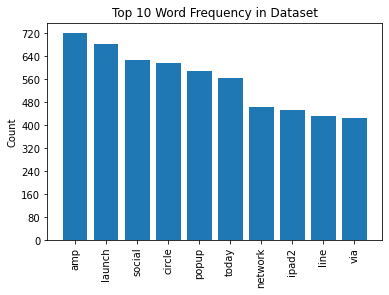

In [59]:
sample_freq_dist = FreqDist(df["clean"].explode())
visualize_top_10(sample_freq_dist, "Top 10 Word Frequency in Dataset")

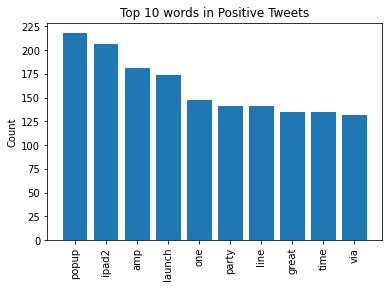

In [60]:
pos_freq_dist = FreqDist(df['clean'].loc[df['target'] == 'Positive emotion'].explode())
visualize_top_10(pos_freq_dist, 'Top 10 words in Positive Tweets')

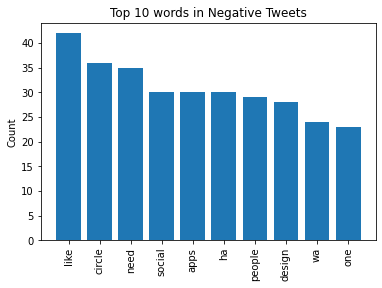

In [61]:
neg_freq_dist = FreqDist(df['clean'].loc[df['target'] == 'Negative emotion'].explode())
visualize_top_10(neg_freq_dist, 'Top 10 words in Negative Tweets')

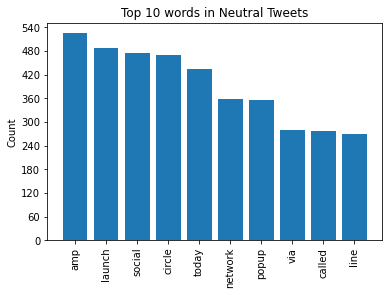

In [62]:
neut_freq_dist = FreqDist(df['clean'].loc[df['target'] == 'No emotion toward brand or product'].explode())
visualize_top_10(neut_freq_dist, 'Top 10 words in Neutral Tweets')

In [63]:
X = df['stop_r']
y = df['target']

## Train Test Split

In [64]:
#Performed the train-test split, using 25% for the hold-out data.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.30)

In [65]:
tfidf = TfidfVectorizer(max_features=9000)

In [66]:
X_train_vectorized = tfidf.fit_transform(X_train)

In [67]:
X_train_vectorized

<6255x8096 sparse matrix of type '<class 'numpy.float64'>'
	with 48314 stored elements in Compressed Sparse Row format>

In [68]:
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())
X_train_vec

,0310apple,100,100tc,103011p,1045am3,105hrs,10k,10mins,10x,10x2,...,ûïspecial,ûïspecials,ûïthe,ûïwin,ûòand,ûó,ûócan,ûólewis,ûólots,ûóthe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
# Transform test data using TF-IDF Vectorizer
X_test_vectorized = tfidf.transform(X_test)
X_test_vectorized

<2681x8096 sparse matrix of type '<class 'numpy.float64'>'
	with 19079 stored elements in Compressed Sparse Row format>

In [70]:
# Convert to DataFrame for visual inspection
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vectorized, columns=tfidf.get_feature_names())
X_test_vec

,0310apple,100,100tc,103011p,1045am3,105hrs,10k,10mins,10x,10x2,...,ûïspecial,ûïspecials,ûïthe,ûïwin,ûòand,ûó,ûócan,ûólewis,ûólots,ûóthe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modeling

In [71]:
# Define max features for all models
max_features = None

In [72]:
# Customer scorers using the weighted average argument, to be used in cross-validation

# Accuracy
accuracy = accuracy_score

#f1
custom_f1 = make_scorer(
    f1_score, 
    average="weighted"
)

# Precision
multi_prec = make_scorer(
    precision_score,
    average="weighted")

# Recall
multi_rec = make_scorer(
    recall_score,
    average="weighted")

# This function will allow for quick cross-validation of the chosen score for each of our models.
def cross_val(model, X, y, custom_scorer, kfolds=5):
    """ Perform cross-validated scoring and store/print results """
    results = cross_val_score(model, X, y, cv=kfolds, scoring=custom_scorer)
    mean = np.mean(results)
    median = np.median(results)
    std = np.std(results)
    if custom_scorer == custom_f1:
        print(f"Mean f1 score: ", {mean}, ".")
        print(f"Median f1 score: ", {median}, ".")
        print(f"Standard Deviation in f1 score: ", {std}, ".") 
    elif custom_scorer == multi_prec:
        print(f"Mean precision score: ", {mean}, ".")
        print(f"Median precision score: ", {median}, ".")
        print(f"Standard Deviation in precision score: ", {std}, ".") 
    elif custom_scorer == multi_rec:
        print(f"Mean recall score: ", {mean}, ".")
        print(f"Median recall score: ", {median}, ".")
        print(f"Standard Deviation in recall score: ", {std}, ".") 

### Dummy Classifier

In [73]:
# Instantiate Dummy Classifier pipeline
dummy_pipe = ImPipeline(steps=[
                                    ('vect', TfidfVectorizer(max_features=max_features)),
                                    ('sm', SMOTE(random_state=42)),
                                    ('dc', DummyClassifier(strategy='constant', constant='No emotion toward brand or product',
                                                           random_state=42))
                                    ]
                            )

0.3644259907821145
0.6036770583533173


/Users/tom/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


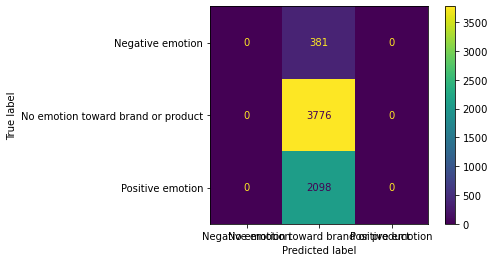

In [74]:
# Fit dummy pipe on the training data, get predictions and plot confusion matrix
dummy_pipe.fit(X_train, y_train)
dummy_yhat = dummy_pipe.predict(X_train)
plot_confusion_matrix(dummy_pipe, X_train, y_train)
print(precision_score(y_train, dummy_yhat, average='weighted'))
print(accuracy_score(y_train, dummy_yhat))

In [75]:
print(classification_report(y_train, dummy_yhat))

                                    precision    recall  f1-score   support

                  Negative emotion       0.00      0.00      0.00       381
No emotion toward brand or product       0.60      1.00      0.75      3776
                  Positive emotion       0.00      0.00      0.00      2098

                          accuracy                           0.60      6255
                         macro avg       0.20      0.33      0.25      6255
                      weighted avg       0.36      0.60      0.45      6255



/Users/tom/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [76]:
# Obtained cross-validated score
print(cross_val(dummy_pipe, X_train, y_train, multi_prec))

acc_score = cross_val_score(dummy_pipe, X_train, y_train, scoring='accuracy').mean()
print(f'Mean Accuracy Score:  {acc_score} .')

/Users/tom/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Mean precision score:  {0.36442609301847095} .
Median precision score:  {0.3642329941003232} .
Standard Deviation in precision score:  {0.00038619783629532104} .
None
Mean Accuracy Score:  0.6036770583533173 .


### FSM - Multinomial Naive Bayes

In [77]:
# Instantiate the MNB Pipeline
mnb_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=max_features)),
                                 #('sm', SMOTE(random_state=42)),
                                 ('mnb', MultinomialNB())
                                ]
                        )

0.8140241678466621

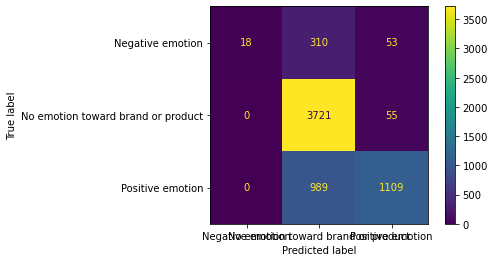

In [78]:
# Fit Multinomial Naive Bayes pipe on the training data, get predictions and plot confusion matrix
mnb_pipe.fit(X_train, y_train)
mnb_y_hat = mnb_pipe.predict(X_train)
plot_confusion_matrix(mnb_pipe, X_train, y_train)
precision_score(y_train, mnb_y_hat, average='weighted')

In [79]:
print(classification_report(y_train, mnb_y_hat))

                                    precision    recall  f1-score   support

                  Negative emotion       1.00      0.05      0.09       381
No emotion toward brand or product       0.74      0.99      0.85      3776
                  Positive emotion       0.91      0.53      0.67      2098

                          accuracy                           0.78      6255
                         macro avg       0.88      0.52      0.54      6255
                      weighted avg       0.81      0.78      0.74      6255



In [80]:
# Obtained cross-validated score
print(cross_val(mnb_pipe, X_train, y_train, multi_prec))

acc_score = cross_val_score(mnb_pipe, X_train, y_train, scoring='accuracy').mean()
print(f'Mean Accuracy Score:  {acc_score} .')

/Users/tom/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Mean precision score:  {0.6814711002104163} .
Median precision score:  {0.696828476519591} .
Standard Deviation in precision score:  {0.028302967702466698} .
None
Mean Accuracy Score:  0.6628297362110311 .


### Logistic Regression

In [81]:
# Instantiate the Logistic Regression Pipeline
logreg_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=max_features)),
                                 ('sm', SMOTE(random_state=42)),
                                 ('lr', LogisticRegression(max_iter=1000))
                                ]
                        )

0.8672647629756974

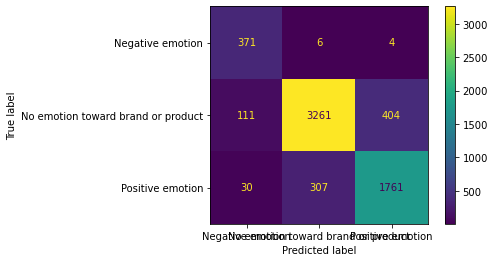

In [82]:
# Fit Logistic Regression pipeline on the training data, get predictions and plot confusion matrix
logreg_pipe.fit(X_train, y_train)
logreg_y_hat = logreg_pipe.predict(X_train)

plot_confusion_matrix(logreg_pipe, X_train, y_train)
precision_score(y_train, logreg_y_hat, average='weighted')

In [83]:
# Obtained cross-validated score
cross_val(logreg_pipe, X_train, y_train, multi_prec)

Mean precision score:  {0.660057062649276} .
Median precision score:  {0.6560886708168046} .
Standard Deviation in precision score:  {0.015685997984594403} .


In [84]:
acc_score = cross_val_score(logreg_pipe, X_train, y_train, scoring='accuracy').mean()
print(f'Mean Accuracy Score:  {acc_score} .')

Mean Accuracy Score:  0.6503597122302158 .


### Linear Support Vector

In [85]:
# Instantiate Linear Support Vector Pipeline
lsv_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=max_features)),
                                 ('sm', SMOTE(random_state=42)),
                                 ('lsv', SGDClassifier(random_state=42))
                                ]
                        )

0.8741508303435167

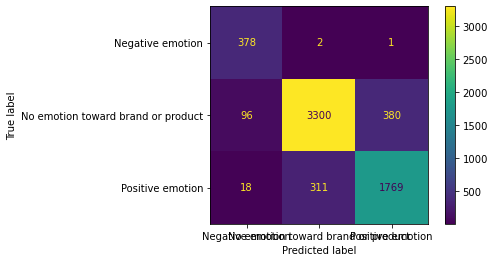

In [86]:
# Fit linear support vector machine on the training data, get predictions and plot confusion matrix
lsv_pipe.fit(X_train, y_train)
lsv_y_hat = lsv_pipe.predict(X_train)

plot_confusion_matrix(lsv_pipe, X_train, y_train)

precision_score(y_train, lsv_y_hat, average='weighted')

In [87]:
# Obtained cross-validated score
cross_val(lsv_pipe, X_train, y_train, multi_prec)

Mean precision score:  {0.6577780115880121} .
Median precision score:  {0.6537625813440935} .
Standard Deviation in precision score:  {0.01707078796105571} .


In [88]:
acc_score = cross_val_score(lsv_pipe, X_train, y_train, scoring='accuracy').mean()
print(f'Mean Accuracy Score:  {acc_score} .')

Mean Accuracy Score:  0.6506794564348521 .


### K-Nearest Neighbors

In [89]:
# Instantiate K-Nearest Neighbors pipeline
knn_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=max_features)),
                                 ('sm', SMOTE(random_state=42)),
                                 ('knn', KNeighborsClassifier())  
                                ]
                        )

0.7924043675627144

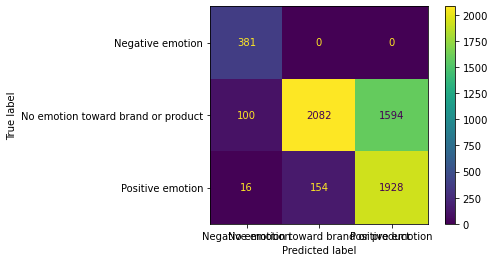

In [90]:
# Fit KNN pipeline on the training data, get predictions and plot confusion matrix
knn_pipe.fit(X_train, y_train)
knn_yhat = knn_pipe.predict(X_train)
plot_confusion_matrix(knn_pipe, X_train, y_train)
precision_score(y_train, knn_yhat, average='weighted') 

In [91]:
# Obtained cross-validated score
cross_val(knn_pipe, X_train, y_train, multi_prec)

Mean precision score:  {0.6244428927807653} .
Median precision score:  {0.6161967240007784} .
Standard Deviation in precision score:  {0.0283977005786864} .


In [92]:
acc_score = cross_val_score(knn_pipe, X_train, y_train, scoring='accuracy').mean()
print(f'Mean Accuracy Score:  {acc_score} .')

Mean Accuracy Score:  0.5547561950439648 .


### RF Classifier

In [93]:
# Instantiate Random Forest pipeline
rf_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=max_features)),
                                 ('sm', SMOTE(random_state=42)),
                                 ('rf', RandomForestClassifier(
                                     #bootstrap= True,
                                    # criterion='gini',
                                    # max_depth=80,
                                    # min_samples_leaf=1,
                                   #  min_samples_split=5,
                                    # n_estimators=100,
                                                                 random_state=42))
                                ]
                        )

0.9627582053243172

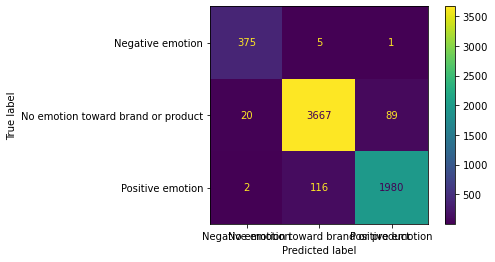

In [94]:
# Fit random forest pipeline on the training data, get predictions and plot confusion matrix
rf_pipe.fit(X_train, y_train)
rfp_yhat = rf_pipe.predict(X_train)
plot_confusion_matrix(rf_pipe, X_train, y_train)
precision_score(y_train, rfp_yhat, average='weighted') 

In [95]:
print(classification_report(y_train, rfp_yhat))

                                    precision    recall  f1-score   support

                  Negative emotion       0.94      0.98      0.96       381
No emotion toward brand or product       0.97      0.97      0.97      3776
                  Positive emotion       0.96      0.94      0.95      2098

                          accuracy                           0.96      6255
                         macro avg       0.96      0.97      0.96      6255
                      weighted avg       0.96      0.96      0.96      6255



In [96]:
# Obtained cross-validated score
cross_val(rf_pipe, X_train, y_train, multi_prec)

Mean precision score:  {0.6636883412368286} .
Median precision score:  {0.6718333789644818} .
Standard Deviation in precision score:  {0.018056363321125295} .


In [97]:
acc_score = cross_val_score(rf_pipe, X_train, y_train, scoring='accuracy').mean()
print(f'Mean Accuracy Score:  {acc_score} .')

Mean Accuracy Score:  0.673701039168665 .


In [98]:
cross_val_score(rf_pipe, X_train, y_train, scoring='accuracy')

array([0.63629097, 0.68185452, 0.66906475, 0.6922462 , 0.68904876])

In [99]:
feat_import = rf_pipe.named_steps['rf'].feature_importances_

In [100]:
feature_names = rf_pipe.named_steps["vect"].get_feature_names()

#### Gridsearch--Random Forest

In [101]:
# Print out original parameters of rf classifier in rf_pipe
print('Current Parameters:\n')
pprint(rf_pipe.named_steps['rf'].get_params())

Current Parameters:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [102]:
# Define new set of parameters to grid-search over
rf_params = {
            'rf__n_estimators': [50, 100, 250],
            'rf__criterion': ['gini', 'entropy'],
            'rf__min_samples_leaf': [1, 2, 4, 6],
            'rf__min_samples_split': [None, 5, 10],
            'rf__max_depth': [None, 30, 50, 100],
            'rf__bootstrap': [True, False],
            'vect__max_features': [None, 4000, 2000, 1000]
             }

# Instantiate grid search object using parameters defined above.
#rf_gs = GridSearchCV(rf_pipe, param_grid=rf_params, n_jobs=-4, verbose=3, cv=10)

# Fit the grid search object on training data
#rf_gs.fit(X_train, y_train)

# Output the best parameters based on the grid search
#rf_gs.best_params_

### Gradient Boosted Classifier

In [103]:
# Instantiate the pipeline
gbc_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=max_features)),
                                 ('sm', SMOTE(random_state=42)),
                                 ('gbc',  GradientBoostingClassifier())
                                ]
                        )

0.7101724987396913

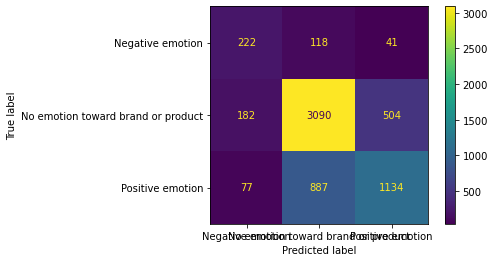

In [104]:
# Fit random forest pipeline on the training data, get predictions and plot confusion matrix
gbc_pipe.fit(X_train, y_train)
gbc_yhat = gbc_pipe.predict(X_train)
plot_confusion_matrix(gbc_pipe, X_train, y_train)
precision_score(y_train, gbc_yhat, average='weighted') 

In [105]:
# Obtained cross-validated score
cross_val(gbc_pipe, X_train, y_train, multi_prec)

Mean precision score:  {0.6344672459092144} .
Median precision score:  {0.6350221522568364} .
Standard Deviation in precision score:  {0.005402530734112988} .


In [106]:
acc_score = cross_val_score(gbc_pipe, X_train, y_train, scoring='accuracy').mean()
print(f'Mean Accuracy Score:  {acc_score} .')

Mean Accuracy Score:  0.6444444444444445 .


In [107]:
# Print out original parameters of gbc classifier in gbc_pipeline
print('Current Parameters:\n')
pprint(gbc_pipe.named_steps['gbc'].get_params())

Current Parameters:

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [108]:
# Define parameter grid to search over
gbc_params = {
            'gbc__n_estimators': [10, 20, 50, 100],
            'gbc__min_samples_leaf': [1, 2, 4, 6],
            'gbc__min_samples_split': [2, 3, 4, 5, 10],
            'gbc__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            'gbc__learning_rate': [0.05, 0.1, 0.2, 0.3]
             }

# Instantiate grid search object using parameters defined above.
#gbc_gs = GridSearchCV(gbc_pipe, param_grid=gbc_params, n_jobs=-2, verbose=3, cv=10)

# Fit the grid search object on training data
#gbc_gs.fit(X_train, y_train)

# Find the best parameters based off of our grid search
#gbc_gs.best_params_

### Model Evaluation